## 2 class softmax using Tensorflow
### Start simple. Match matlab output. Sets a benchmark

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
from IPython import display # For plotting intermediate results

In [3]:
import pandas as pd
import seaborn as sns 
import random
from scipy.signal import resample
from scipy.stats import zscore

/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [5]:
# data loading function
def data_loader(mouse_name):
    theta = pd.read_csv('~/work/whiskfree/data/theta_' + mouse_name + '.csv',header=None)
    kappa = pd.read_csv('~/work/whiskfree/data/kappa_' + mouse_name + '.csv',header=None)
    tt = pd.read_csv('~/work/whiskfree/data/trialtype_' + mouse_name + '.csv',header=None)
    ch = pd.read_csv('~/work/whiskfree/data/choice_' + mouse_name + '.csv',header=None)

    return theta, kappa, tt, ch

def data_parser(theta,kappa,tt,ch,tt_ch):
    
    theta_r = np.array([[resample(theta.values.squeeze()[i,950:1440],50)] for i in range(0,theta.shape[0])])
    theta_r = zscore(theta_r.squeeze(),axis=None)

    kappa_r = np.array([[resample(kappa.values.squeeze()[i,950:1440],50)] for i in range(0,kappa.shape[0])])
    kappa_r = zscore(kappa_r.squeeze(),axis=None)

    kappa_df = pd.DataFrame(kappa_r)
    theta_df = pd.DataFrame(theta_r)

    both_df = pd.concat([theta_df,kappa_df],axis=1)
    
    if tt_ch == 'tt':
        # trial type
        clean1 = tt.values == 1
        clean2 = tt.values == 2
        tt_c = tt[clean1|clean2].values
    else :
        # choice
        clean1 = ch.values == 1
        clean2 = ch.values == 2
        tt_c = ch[clean1|clean2].values

    # tt_c = tt[tt.values !=0|3].values
    both = both_df.values
    # both_c = both[clean.squeeze(),:]
    both_c = both[clean1.squeeze()|clean2.squeeze(),:]
    labs = np.eye(2)[tt_c.astype(int)-1]
    # y[np.arange(3), a] = 1
    labs = labs.squeeze()
    
    return labs, both_c, tt_c, clean1, clean2

In [ ]:
# Import the data using function
mouse_name = '36'
theta, kappa, tt, ch = data_loader(mouse_name)

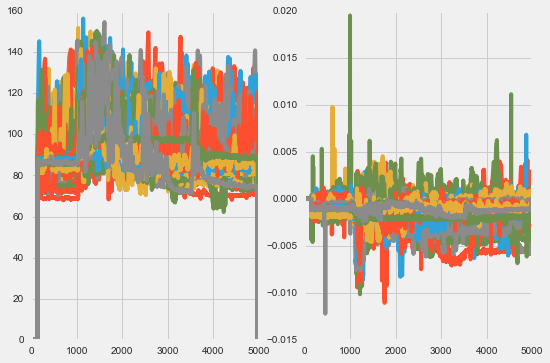

In [199]:
fig, ax = plt.subplots(1,2)
_ = ax[0].plot(theta[:100].T)
_ = ax[1].plot(kappa[:100].T)

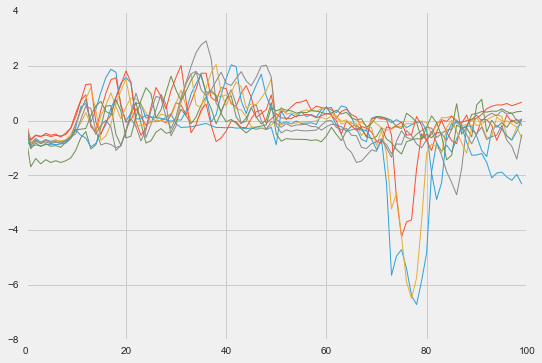

In [228]:
# Parse data into correct format for analysis
labs, both_c, tt_c, clean1, clean2 = data_parser(theta,kappa,tt,ch,'tt')
_ = plt.plot(both_c[:10].T,lw=1)

In [200]:
# Let's use 20% of the data for testing and 80% for training
trainsize = int(len(both_c) * 0.8)
testsize = len(both_c) - trainsize
print('Desired training/test set sizes:',trainsize, testsize)

subset = random.sample(range(len(both_c)),trainsize)
fullrange = range(0,len(both_c))
toexclude = np.delete(fullrange,subset)
traindata = both_c[subset,:]
trainlabs = labs[subset,:]
testdata = np.delete(both_c,subset,axis=0)
testlabs = np.delete(labs,subset,axis=0)

# non one-hot style labels
trainlabs1D = tt_c[subset].squeeze()
testlabs1D = np.delete(tt_c,subset)

print('training set shape:',traindata.shape)
print('test set shape:',testdata.shape)
print('training labels shape:',trainlabs.shape)
print('test labels shape:',testlabs.shape)
print('1D train label shape:', trainlabs1D.shape)
print('1D test label shape:', testlabs1D.shape)

Desired training/test set sizes: 909 228
training set shape: (909, 100)
test set shape: (228, 100)
training labels shape: (909, 2)
test labels shape: (228, 2)
1D train label shape: (909,)
1D test label shape: (228,)


In [222]:
# compare with sklearn
lr = LogisticRegression()
lr.fit(traindata,trainlabs1D)

print(accuracy_score(testlabs1D,lr.predict(testdata)))
print(accuracy_score(tt_c,lr.predict(both_c)))

0.561403508772
0.617414248021


In [208]:
# SVM
from sklearn import svm
lin_svm = svm.LinearSVC()
# lin_svm.fit(traindata,trainlabs[:,1])
lin_svm.fit(both_c,labs[:,1])

print(accuracy_score(testlabs[:,1],lin_svm.predict(testdata)))
print(accuracy_score(labs[:,1],lin_svm.predict(both_c)))
scores_svm = cross_validation.cross_val_score(lin_svm,  both_c, labs[:,1],cv=5,scoring='accuracy')

preds_svm = cross_validation.cross_val_predict(lin_svm,  both_c, labs[:,1],cv=5)
print(scores_svm)
print(np.mean(scores_svm))

0.609649122807
0.624450307828
[ 0.49561404  0.49561404  0.49122807  0.51982379  0.50884956]
0.502225897284


In [209]:
# cross_validation.cross_val_predict?
accuracy_score(labs[:,1],preds_svm)

0.50571679859278806

In [223]:
# compare with a DNN using skflow
import tensorflow.contrib.learn as skflow

classifier = skflow.TensorFlowDNNClassifier(hidden_units=[50,50], n_classes=2,batch_size=128, steps=1000, optimizer = 'Adam',learning_rate=0.01)
classifier.fit(traindata, trainlabs[:,1]) #,logdir='/tmp/tf_examples/skflow_dnn_model_1/')
print(metrics.accuracy_score(testlabs[:,1], classifier.predict(testdata)))
print(metrics.accuracy_score(labs[:,1], classifier.predict(both_c)))

Step #100, epoch #12, avg. train loss: 0.65314
Step #200, epoch #25, avg. train loss: 0.47144
Step #300, epoch #37, avg. train loss: 0.29953
Step #400, epoch #50, avg. train loss: 0.16271
Step #500, epoch #62, avg. train loss: 0.10119
Step #600, epoch #75, avg. train loss: 0.05737
Step #700, epoch #87, avg. train loss: 0.08746
Step #800, epoch #100, avg. train loss: 0.03086
Step #900, epoch #112, avg. train loss: 0.01232
Step #1000, epoch #125, avg. train loss: 0.01095
0.517543859649
0.897977132806


In [224]:
# Going deeper
classifier2 = skflow.TensorFlowDNNClassifier(hidden_units=[10, 20, 20, 10], n_classes=2,batch_size=128, steps=1000, optimizer='Adam', learning_rate=0.01)
classifier2.fit(traindata, trainlabs[:,1])
print(metrics.accuracy_score(testlabs[:,1], classifier2.predict(testdata)))
print(metrics.accuracy_score(labs[:,1], classifier2.predict(both_c)))

Step #100, epoch #12, avg. train loss: 0.65932
Step #200, epoch #25, avg. train loss: 0.54338
Step #300, epoch #37, avg. train loss: 0.45825
Step #400, epoch #50, avg. train loss: 0.41376
Step #500, epoch #62, avg. train loss: 0.30403
Step #600, epoch #75, avg. train loss: 0.29284
Step #700, epoch #87, avg. train loss: 0.24320
Step #800, epoch #100, avg. train loss: 0.21756
Step #900, epoch #112, avg. train loss: 0.18948
Step #1000, epoch #125, avg. train loss: 0.19622
0.517543859649
0.850483729112


Mouse Accuracy = 0.79
LR Accuracy = 0.23
DNN Accuracy = 0.90
Deeper NN Accuracy = 0.85


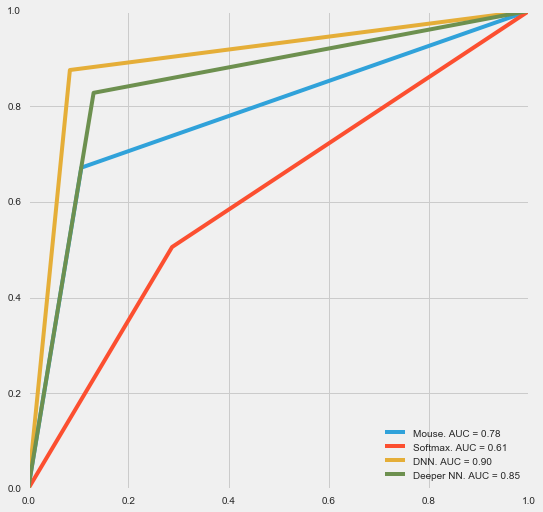

In [225]:
# Plot ROC curves and print AUC for all models and mouse

# DNN
dnnp = classifier.predict(both_c)
fpr,tpr,thresholds = metrics.roc_curve(labs[:,1],dnnp)

# LR
lrp = lr.predict(both_c)
fpr2,tpr2,thresholds2 = metrics.roc_curve(labs[:,1],lrp)

# Deeper NN
dnn2p = classifier2.predict(both_c)
fpr4,tpr4,thresholds4 = metrics.roc_curve(labs[:,1],dnn2p)

# Mouse
mouse_choice = ch[clean1|clean2].values
# Set all non-choice-1 as choice 2
mouse_choice_b = mouse_choice
mouse_choice_b[mouse_choice_b !=2]  = 1
fpr3,tpr3,thresholds3 = metrics.roc_curve(labs[:,1],mouse_choice-1)


with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.plot(fpr3,tpr3,label = 'Mouse. AUC = %0.2f'% metrics.roc_auc_score(labs[:,1],mouse_choice-1))
    plt.plot(fpr2,tpr2, label = 'Softmax. AUC = %0.2f'% metrics.roc_auc_score(labs[:,1],lrp))
    plt.plot(fpr,tpr,label = 'DNN. AUC = %0.2f'% metrics.roc_auc_score(labs[:,1],dnnp))
    plt.plot(fpr4,tpr4,label = 'Deeper NN. AUC = %0.2f'% metrics.roc_auc_score(labs[:,1],dnn2p))
    plt.legend(loc=4)


    
print('Mouse Accuracy = %0.2f'% metrics.accuracy_score(labs[:,1],mouse_choice-1))
print('LR Accuracy = %0.2f'% metrics.accuracy_score(labs[:,1],lrp))
print('DNN Accuracy = %0.2f'% metrics.accuracy_score(labs[:,1],dnnp))
print('Deeper NN Accuracy = %0.2f'% metrics.accuracy_score(labs[:,1],dnn2p))

plt.savefig('ROC_TT_all_'+ mouse_name +'.png')

### Repeat plotting but only train using test set

Mouse Accuracy = 0.79
LR Accuracy = 0.25
DNN Accuracy = 0.52
Deeper NN Accuracy = 0.52


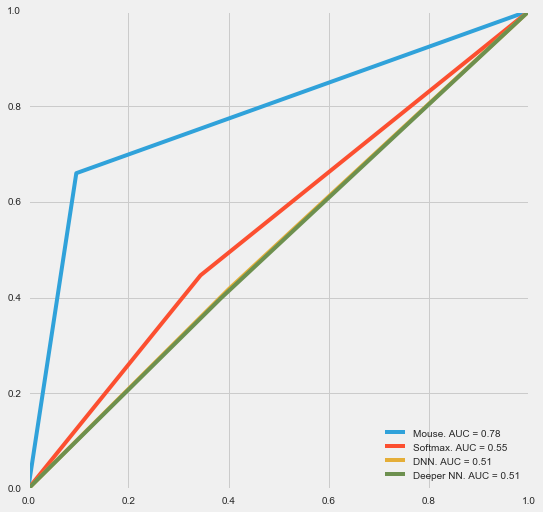

In [226]:
# Plot ROC curves and print AUC for all models and mouse TEST DATA

# DNN
dnnp = classifier.predict(testdata)
fpr,tpr,thresholds = metrics.roc_curve(testlabs[:,1],dnnp)

# LR
lrp = lr.predict(testdata)
fpr2,tpr2,thresholds2 = metrics.roc_curve(testlabs[:,1],lrp)

# Deeper NN
dnn2p = classifier2.predict(testdata)
fpr4,tpr4,thresholds4 = metrics.roc_curve(testlabs[:,1],dnn2p)

# Mouse
mouse_choice = ch[clean1|clean2].values
# Set all non-choice-1 as choice 2
mouse_choice_b = mouse_choice
mouse_choice_b[mouse_choice_b !=2]  = 1
fpr3,tpr3,thresholds3 = metrics.roc_curve(testlabs[:,1],mouse_choice[toexclude]-1)


with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.plot(fpr3,tpr3,label = 'Mouse. AUC = %0.2f'% metrics.roc_auc_score(testlabs[:,1],mouse_choice[toexclude]-1))
    plt.plot(fpr2,tpr2, label = 'Softmax. AUC = %0.2f'% metrics.roc_auc_score(testlabs[:,1],lrp))
    plt.plot(fpr,tpr,label = 'DNN. AUC = %0.2f'% metrics.roc_auc_score(testlabs[:,1],dnnp))
    plt.plot(fpr4,tpr4,label = 'Deeper NN. AUC = %0.2f'% metrics.roc_auc_score(testlabs[:,1],dnn2p))
    plt.legend(loc=4)


    
print('Mouse Accuracy = %0.2f'% metrics.accuracy_score(testlabs[:,1],mouse_choice[toexclude]-1))
print('LR Accuracy = %0.2f'% metrics.accuracy_score(testlabs[:,1],lrp))
print('DNN Accuracy = %0.2f'% metrics.accuracy_score(testlabs[:,1],dnnp))
print('Deeper NN Accuracy = %0.2f'% metrics.accuracy_score(testlabs[:,1],dnn2p))

plt.savefig('ROC_TT_test_'+ mouse_name +'.png')

## Big loop that performs cross-validation to see how test set choice affects performance

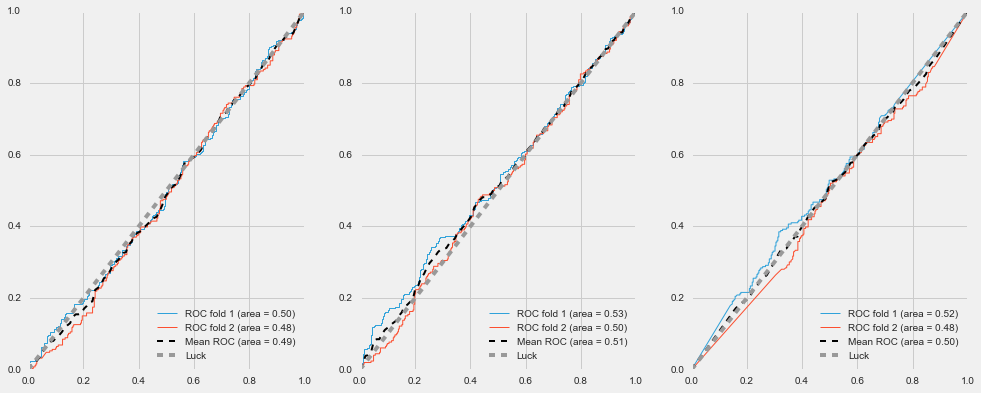

In [218]:
from sklearn.cross_validation import KFold
from scipy import interp

cv = KFold(len(labs[:,1]), n_folds=2,shuffle=True)

lg = LogisticRegression()
classifier = skflow.TensorFlowDNNClassifier(hidden_units=[50], n_classes=2,batch_size=128, steps=1000, optimizer = 'Adam',learning_rate = 0.001,verbose=0)
classifier2 = skflow.TensorFlowDNNClassifier(hidden_units=[10, 20, 20, 10], n_classes=2,batch_size=128, steps=1000, optimizer='Adam', learning_rate=0.01,verbose=0)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

fig, ax = plt.subplots(1,3,figsize=(15,6))
axes = ax.flat

for j in range(0,3):
    if j == 0:
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        all_tpr = []
        ax = next(axes)
        for i, (train, test) in enumerate(cv):
            
            # Logisitic regression
            probas_ = lg.fit(both_c[train], labs[train,1]).predict_proba(both_c[test])
            # Compute ROC curve and area the curve
            fpr, tpr, thresholdsl = metrics.roc_curve(labs[test,1], probas_[:,1])
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            
            roc_auc = metrics.auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
            
            
        mean_tpr /= len(cv)
        mean_tpr[-1] = 1.0
        mean_auc = metrics.auc(mean_fpr, mean_tpr)
        ax.plot(mean_fpr, mean_tpr, 'k--',
        label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
        ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
        ax.legend(loc=4)
    
    if j == 1:
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        all_tpr = []
        ax = next(axes)
        for i, (train, test) in enumerate(cv):
            # DNN Classifier
            probas_c = classifier.fit(both_c[train,:], labs[train,1]).predict_proba(both_c[test,:])
            fpr, tpr, thresholds = metrics.roc_curve(labs[test,1], probas_c[:,1]) #probas_c[:,1]
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            roc_auc = metrics.auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
            
        mean_tpr /= len(cv)
        mean_tpr[-1] = 1.0
        mean_auc = metrics.auc(mean_fpr, mean_tpr)
        ax.plot(mean_fpr, mean_tpr, 'k--',
        label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
        ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
        ax.legend(loc=4)

    if j == 2:
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        all_tpr = []
        ax = next(axes)
        for i, (train, test) in enumerate(cv):
            # DNN 2
            probas_c2 = classifier2.fit(both_c[train], labs[train,1]).predict_proba(both_c[test])
            fpr, tpr, thresholds = metrics.roc_curve(labs[test,1], probas_c2[:, 1])
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            roc_auc = metrics.auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
            
        mean_tpr /= len(cv)
        mean_tpr[-1] = 1.0
        mean_auc = metrics.auc(mean_fpr, mean_tpr)
        ax.plot(mean_fpr, mean_tpr, 'k--',
        label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
        ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
        ax.legend(loc=4)
    
    
    
# bx[0].legend(loc=4)
# bx[1].legend(loc=4)
# bx[2].legend(loc=4)

# plt.savefig('ROC_TT_crossval_3_'+ mouse_name +'.png')

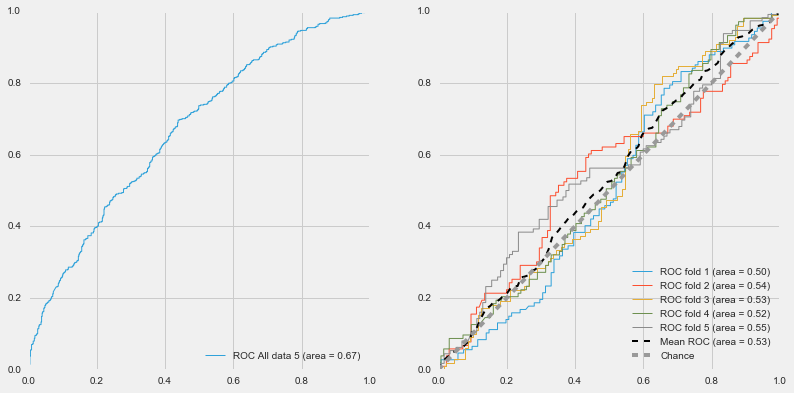

In [216]:
# Repeat but only on logistic regression. Trying to see what's going on
cv = KFold(len(labs[:,1]), n_folds=5,shuffle=True)

lg = LogisticRegression()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

fig, ax = plt.subplots(1,2,figsize=(12,6))

# Plot one time, all data version
probas_ = lg.fit(both_c, labs[:,1]).predict_proba(both_c)
# Compute ROC curve and area the curve
fpr, tpr, thresholdsl = metrics.roc_curve(labs[:,1], probas_[:,1])
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, lw=1, label='ROC All data %d (area = %0.2f)' % (i+1, roc_auc))
ax[0].legend(loc=4)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):

    # Logisitic regression
    probas_ = lg.fit(both_c[train], labs[train,1]).predict_proba(both_c[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholdsl = metrics.roc_curve(labs[test,1], probas_[:,1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0

    roc_auc = metrics.auc(fpr, tpr)
    ax[1].plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))


mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
ax[1].plot(mean_fpr, mean_tpr, 'k--',
label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
ax[1].plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
ax[1].legend(loc=4)

(909,)
(228,)
(909,)
(228,)
(910,)
(227,)
(910,)
(227,)
(910,)
(227,)


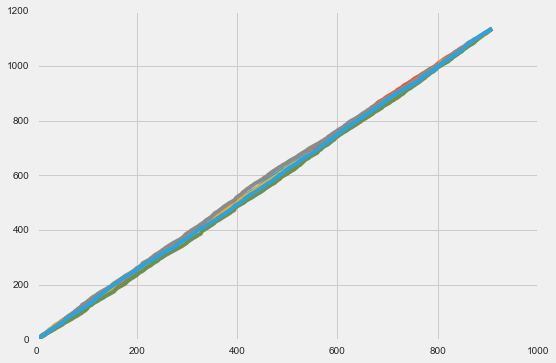

In [157]:
cv = KFold(len(labs[:,1]), n_folds=5,shuffle=True)
# fig, ax = plt.subplots(5)
for i, (train, test) in enumerate(cv):
    print(train.shape)
    print(test.shape)
#     ax[i].hist(train)
    plt.plot(train)

plt.plot(np.sort(subset))

In [178]:

# print(both_c.shape)
# print(labs.shape)
# print(probas_c.shape)
# print(test.shape)
# print(train.shape)
# plt.hist(subset)
skflow.TensorFlowDNNClassifier?

In [137]:
# Cross validation example
from sklearn import cross_validation
lr = LogisticRegression()
lr.fit(traindata,trainlabs[:,1])

print(accuracy_score(testlabs[:,1],lr.predict(testdata)))
print(accuracy_score(labs[:,1],lr.predict(both_c)))

scores = cross_validation.cross_val_score(lr, both_c, labs[:,1], cv=4,scoring='f1_weighted')

print(scores)
print(np.mean(scores))
# scores.

0.543859649123
0.60510114336
[ 0.50103809  0.50634479  0.4877193   0.48088447]
0.493996661392


## Custom TF example (following TF docs)

In [11]:
# Construct the data flow graph following the TF beginner's MNIST example
x = tf.placeholder(tf.float32,[None,100]) # data

W = tf.Variable(tf.zeros([100,2])) # W and b are model variables to be fit by the model
b = tf.Variable(tf.zeros([2]))     # 2 possible trial types

y = tf.nn.softmax(tf.matmul(x,W) + b) # This is the softmax nn model

y_ = tf.placeholder(tf.float32,[None,2]) # Placeholder for correct answers (test labels)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])) # Cross entropy loss

# train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy) # training step
train_step = tf.train.AdamOptimizer().minimize(cross_entropy) # training step using Adam optimizer

In [12]:
# Function to load a random batch of data
def next_batch(data,labels,n):
    subset = random.sample(range(len(data)),n) 
    batch_data = data[subset,:]
    batch_labels = labels[subset,:]
    
    return batch_data, batch_labels

In [ ]:
# Set wheels in motion and train the model
init = tf.initialize_all_variables()
sess = tf.Session() # Start tf session
sess.run(init)

In [ ]:
sess.close()

In [ ]:
sess.run(tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])), feed_dict = {x: batch_xs, y_:batch_ys})

In [ ]:
# Run a training loop
for i in range(10000):
    batch_xs, batch_ys = next_batch(traindata,trainlabs,250)
    sess.run(train_step,feed_dict={x: batch_xs, y_: batch_ys})
    if i%1000 == 0:
        print ('{0} error={1}'.format(i, sess.run(tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])), feed_dict = {x: batch_xs, y_:batch_ys})))

In [14]:
# sess.close()
init = tf.initialize_all_variables()
sess = tf.Session() # Start tf session
sess.run(init)
# Try using more data on each time step (all data?)
for i in range(1000):
    sess.run(train_step,feed_dict={x:traindata,y_:trainlabs})
    if i%100 ==0:
        print ('{0} error={1}'.format(i, sess.run(tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])), feed_dict = {x: batch_xs, y_:batch_ys})))
        
        

NameError: name 'batch_xs' is not defined

In [ ]:
# Evaluate model performance
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
print(sess.run(accuracy,feed_dict={x: testdata,y_:testlabs}))

In [ ]:
trainlabs.shape

In [ ]:
# Confusion matrix for model
all_preds = sess.run(y,feed_dict={x:both_c})
cm_tf = confusion_matrix(np.argmax(labs,1),np.argmax(all_preds,1))

# Confusion matrix for the mouse
# Trial Type
clean1 = tt.values == 1
clean2 = tt.values == 2
# choice
# clean1 = ch.values == 1
# clean2 = ch.values == 2
mouse_choice = tt[clean1|clean2].values
# Set all non-choice-1 as choice 2
mouse_choice_b = mouse_choice
mouse_choice_b[mouse_choice_b !=1]  =2

cm_m = confusion_matrix(tt_c,mouse_choice_b)

print('Confusion matrix (mouse):\n',cm_m)
print('Confusion matrix (model):\n',cm_tf)
print('Mouse overall accuracy = ',accuracy_score(tt_c,mouse_choice_b))
print('Model overall accuracy = ',accuracy_score(np.argmax(labs,1),np.argmax(all_preds,1)))

with sns.axes_style("white"):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(cm_m,interpolation='none',cmap='coolwarm')
    ax[1].imshow(cm_tf,interpolation='none',cmap='coolwarm')

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].hist(np.argmax(all_preds,1))
ax[1].hist(np.argmax(labs,1))

In [ ]:
preds = sess.run(y,feed_dict={x:testdata})
with sns.axes_style("white"):
    fig, ax = plt.subplots(2,1,figsize=[20,1])
ax[0].imshow(preds.T,interpolation='none',aspect = 3)
ax[1].imshow(testlabs.T,interpolation='none',aspect = 3)
accuracy_score(np.argmax(testlabs,1),np.argmax(preds,1))

In [ ]:
clean1 = tt.values == 1
clean2 = tt.values == 2
# tt_c = tt[tt.values !=0|3].values
tt_c = tt[clean1|clean2].values
# plt.plot(tt[clean|clean2])
plt.plot(tt_c)

In [ ]:
both = both_df.values
# both_c = both[clean.squeeze(),:]
both_c = both[clean1.squeeze()|clean2.squeeze(),:]

In [ ]:
both.shape

In [ ]:
both_c.shape

In [ ]:
np.eye(2)[tt_c.astype(int) -1]

In [ ]:
# metrics.roc_auc_score?
lrp = lr.predict(both_c)
dnnp = classifier.predict(both_c)
# print(metrics.roc_auc_score(labs[:,1],all_preds[:,1]))
print(metrics.roc_auc_score(labs[:,1],lrp))
print(metrics.roc_auc_score(labs[:,1],dnnp))
# roc = metrics.roc_curve(labs[:,0],all_preds[:,0],1)

In [ ]:
plt.plot(ch[:100])
plt.plot(mouse_choice_b[:100])
plt.plot(mouse_choice[:100])
# plt.plot(labs[:100,1])
labs.shape

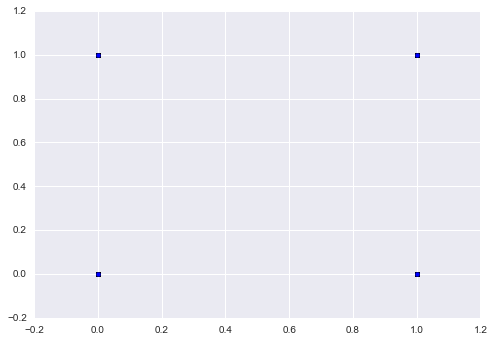

In [20]:
plt.scatter(labs[:,1],lrp)

In [ ]:
metrics.classification?

In [ ]:
mice = ['32','33','34','36']
for a in range(0,4):
    filename = '~/work/whiskfree/data/theta_' + mice[a] + '.csv'
    print(filename)


In [ ]:
_ = plt.plot(both_c[:100].T)

In [ ]:
sess.close()